# $SAR_{10g}$ Hotspot Position Prediction Model

* **Author**: Shayan Dodge 
* **Email**: dodgeshayan@gmail.com

This notebook demonstrates the complete pipeline for predicting Specific Absorption Rate (SAR) hotspot position using deep learning. It includes the following steps:
1. *Data Preprocessing*: Loading and processing SAR data and images, including resizing images and normalizing inputs.
2. *Model Architecture*: Building a multi-input model that combines Convolutional Neural Networks (CNNs) for image processing and fully connected layers for frequency input.
3. *Model Training*: Compiling and training the model using the training dataset, with early stopping to prevent overfitting.
4. *Performance Evaluation*: Evaluating the model’s performance using Mean Absolute Error (MAE) and Mean Squared Error (MSE) metrics on the test dataset.

By the end of this notebook, you will have a trained model capable of predicting SAR positions based on images and frequency inputs, along with performance metrics to assess its accuracy.


## 1. Image and Metadata Processing for Model Training

* This section demonstrates the process of loading and preprocessing images along with their associated metadata (SAR values and frequencies). 

* The data is then split into training, validation, and test sets to prepare for model training.

In [6]:
import os
import json
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Enable eager execution for TensorFlow (allows operations to execute immediately)
tf.compat.v1.enable_eager_execution()

# Define paths to your data
image_folder = 'normal'  # Path to folder containing images
csv_file = 'normal/SAR_MaxValues.csv'  # Path to CSV file containing image metadata

# Desired image shape after resizing
IMG_SHAPE = (56, 106)
target_size = (56, 106)

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_file)

# Function to load images and their corresponding bounding boxes from CSV metadata
def load_images(df, image_folder, target_size=IMG_SHAPE):
    images = []  # List to store the image arrays
    labels = []  # List to store frequency labels
    targets = []  # List to store target coordinates (x, y)

    for index, row in df.iterrows():
        image_name = row['z']  # Image name from CSV (not used in loading, but could be useful)
        image_path = os.path.join(image_folder, str(int(row['z'])) + '_' + str(int(row['f'])) + '.png')  # Path to the image file

        # Load and resize the image
        img = Image.open(image_path)
        original_width, original_height = img.size  # Get original dimensions of the image
        img = img.resize(target_size)  # Resize image to the desired shape
        img_array = np.array(img)  # Convert resized image to numpy array

        # Extracting location of hotspot and frequency from the row
        x = round(row['x'] * target_size[0] / original_width)  # Adjust x-coordinate based on resizing
        y = round(row['y'] * target_size[1] / original_height)  # Adjust y-coordinate based on resizing
        f = row['f']  # Frequency value (label)

        # Convert frequency and target coordinates into numpy arrays
        label_array = np.array((f))  # Convert frequency into a numpy array
        targets_array = np.array((x, y))  # Convert (x, y) coordinates into a numpy array

        # Append data to respective lists
        images.append(img_array)
        labels.append(label_array)
        targets.append(targets_array)

    return images, labels, targets

# Load images and their corresponding bounding boxes from CSV
images, labels, targets = load_images(df, image_folder, target_size)

# Convert lists of images, labels, and targets into numpy arrays
images_np = np.array(images)
labels_np = np.array(labels)
targets_np = np.array(targets)

# Preprocessing function to normalize images and prepare data for training
def preprocess(image, numerical, target):
    # Normalize image data to range [0, 1] by dividing by 255 (scaling pixel values)
    image = tf.cast(image, tf.float32) / 255  # Ensure the image is float32 and normalized
    return (image, numerical), target  # Return a tuple of (inputs, targets)

# Create TensorFlow Dataset from the numpy arrays
dataset = tf.data.Dataset.from_tensor_slices((images_np, labels_np, targets_np))

buffer_size = 2000  # Adjust the buffer size for shuffling the dataset
seed = 42  # Set a fixed seed for reproducibility of shuffling

# Shuffle the dataset
shuffled_dataset = dataset.shuffle(buffer_size, seed=seed)

# Split the dataset into training, validation, and test sets
dataset_size = len(images_np)
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)  # 15% for validation
test_size = dataset_size - train_size - val_size  # Remaining for test

# Split the dataset
train_dataset = shuffled_dataset.take(train_size)

remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(test_size)

# Preprocess, batch, and shuffle the datasets for training
batch_size = 16  # Set batch size for training

# Apply preprocessing function, shuffle, and batch the datasets
train_dataset = train_dataset.map(preprocess).shuffle(buffer_size=train_size).batch(batch_size)
val_dataset = val_dataset.map(preprocess).batch(batch_size)  # No need to shuffle validation/test sets
test_dataset = test_dataset.map(preprocess).batch(batch_size)

# Print dataset sizes
print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")
print(f"Test dataset size: {test_size}")


Train dataset size: 946
Validation dataset size: 202
Test dataset size: 204


## 2. Visualizing Image Batches with Metadata

* This section visualizes a batch of images from the training dataset, displaying each image along with its associated frequency (f) and standardized SAR value.

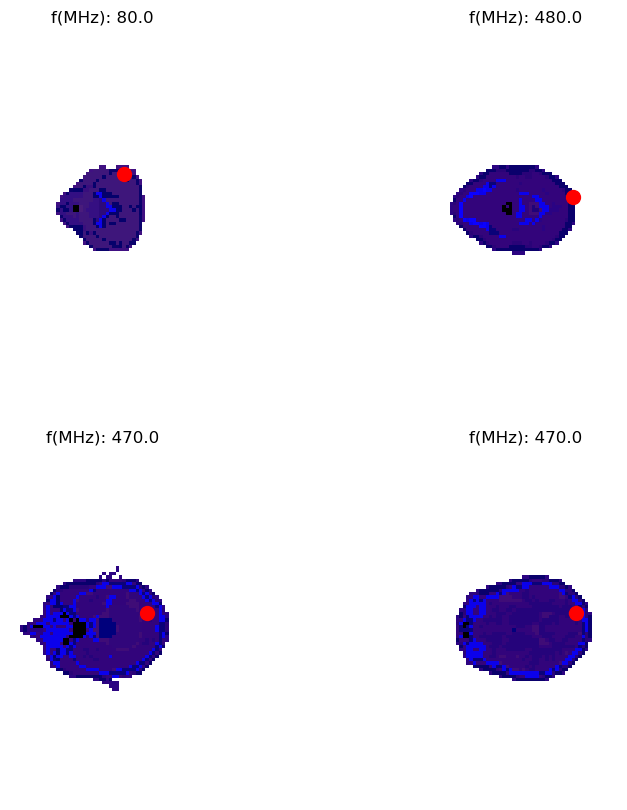

In [7]:
# Assume your dataset is called 'dataset'
# Iterate through the dataset and extract one batch
for (images, labels), targets in train_dataset.take(1):
    # images is a batch of images, labels contain the corresponding labels, targets are additional targets

    # Convert the tensor to a numpy array for plotting
    image_batch = images.numpy()
    f = labels.numpy()
    x = targets.numpy()

    # Visualize a few images along with their labels and targets
    plt.figure(figsize=(10, 10))
    for i in range(4):  # Display the first 9 images
        plt.subplot(2, 2, i + 1)
        plt.imshow(image_batch[i])
        plt.plot( x[i][0], x[i][1], 'ro', markersize=10) 
        plt.title(f"f(MHz): {f[i]}")
        plt.axis('off')
    plt.show()

## 3. Creating Multi-Input Convolutional Neural Network

* The model processes two types of input:
    1. *Image Input*: A convolutional neural network (CNN) extracts features from images.
    2. *Frequency Input*: A dense network processes a single scalar frequency value.

* The outputs from both branches are concatenated and passed through dense layers to predict the Specific Absorption Rate (SAR) hotspot positions, ensuring accuracy in hotspot localization. 

In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dropout
from keras.layers import LeakyReLU

# Define the input for the image branch
# Assuming the images are resized to (71, 71) with 3 color channels (RGB)
image_input = Input(shape=(IMG_SHAPE[1], IMG_SHAPE[0], 3))

# Convolutional Neural Network (CNN) Layers for image processing
x = Conv2D(32, (3, 3), activation='relu')(image_input)  # 32 filters, 3x3 kernel, ReLU activation
x = MaxPooling2D((2, 2))(x)  # Downsample the feature maps using 2x2 max pooling
x = Conv2D(32, (3, 3), activation='relu')(x)  # Another convolutional layer
x = MaxPooling2D((2, 2))(x)  # Another max pooling layer
x = Conv2D(64, (3, 3), activation='relu')(x)  # Increase filters to 64 for deeper features
x = MaxPooling2D((2, 2))(x)  # Final max pooling layer
x = Flatten()(x)  # Flatten the 2D feature maps into a 1D feature vector
x = Dense(128, activation='relu')(x)  # Fully connected layer with 128 units

# Define the input for the frequency branch
# Frequency is represented as a single scalar value
freq_input = Input(shape=(1,))

# Dense layers for frequency processing
f = Dense(8, activation='relu')(freq_input)  # Map the frequency input to an 8-dimensional space

# Combine (concatenate) the feature vectors from the image and frequency branches
combined = Concatenate()([x, f])

# Fully connected layers after concatenation
output = Dense(8, activation='relu')(combined)  # Additional dense layer to process combined features

# Output layer for predicting the (x, y) hotspot coordinates
position_output = Dense(2)(output)  # Final output layer with 2 units (x and y coordinates)

# Define the model with image and frequency inputs and position output
model = Model(inputs=[image_input, freq_input], outputs=position_output)

# Define a custom loss function for the model
# The Euclidean distance loss measures the distance between true and predicted coordinates
def euclidean_distance_loss(true, pred):
    true = tf.cast(true, tf.float32)  # Ensure true labels are in float32
    pred = tf.cast(pred, tf.float32)  # Ensure predictions are in float32
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(true - pred), axis=1)))  # Calculate mean Euclidean distance

# Compile the model with the Adam optimizer and the custom Euclidean distance loss function
model.compile(optimizer=Adam(), loss=euclidean_distance_loss)

# Print a summary of the model architecture
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 106, 56, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 104, 54, 32)  896         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 52, 27, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 50, 25, 32)   9248        ['max_pooling2d_3[0][0]']  

## 4. Model Training with Early Stopping

* This section trains a deep learning model using early stopping to prevent overfitting. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define a function for exponential learning rate decay
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
            return lr0 #* 0.1**(epoch / s)
    return exponential_decay_fn

# Set up exponential decay function with initial learning rate lr0=0.01 and s = 20
exponential_decay_fn = exponential_decay(lr0=10e-4, s=10 ) # 50

# Set up LearningRateScheduler callback using exponential decay function
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Early stopping for the validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience = 100 , restore_best_weights=True)

# Fit the model
model.fit(train_dataset, validation_data=val_dataset,batch_size=batch_size, epochs=500, callbacks=[lr_scheduler,early_stopping]) # lr_scheduler

Epoch 1/500
60/60 [==============================] - 2s 33ms/step - loss: 18.8420 - val_loss: 10.9018 - lr: 0.0010
Epoch 2/500
60/60 [==============================] - 2s 35ms/step - loss: 8.7265 - val_loss: 7.7443 - lr: 0.0010
Epoch 3/500
60/60 [==============================] - 2s 29ms/step - loss: 7.3284 - val_loss: 8.1013 - lr: 0.0010
Epoch 4/500
60/60 [==============================] - 2s 29ms/step - loss: 6.4924 - val_loss: 6.9819 - lr: 0.0010
Epoch 5/500
60/60 [==============================] - 2s 30ms/step - loss: 6.5031 - val_loss: 6.0278 - lr: 0.0010
Epoch 6/500
60/60 [==============================] - 2s 30ms/step - loss: 5.8861 - val_loss: 5.3523 - lr: 0.0010
Epoch 7/500


## 5. Saving the Trained Model

* This section demonstrates how to save the trained deep learning model to an HDF5 file format (`pos_model.h5`).


In [5]:
# # Save the model to a file
# model.save('pos_model.h5')  # Use the .h5 extension to save in HDF5 format

## 6. Loading the Saved Model

* This section demonstrates how to load a previously saved deep learning model from an HDF5 file (`pos_model.h5`).


In [6]:
# from tensorflow.keras.models import load_model

## Define a function for exponential learning rate decay
# def euclidean_distance_loss(true, pred):
#     true = tf.cast(true, tf.float32)  # Ensure true is float32
#     pred = tf.cast(pred, tf.float32)  # Ensure pred is float32
#     return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(true - pred), axis=1)))

# # Load the model from the file
# model = load_model('pos_model.h5', custom_objects={'euclidean_distance_loss': euclidean_distance_loss})

## 7. Comparison of Predicted vs Actual Positions

* This plot visualizes the comparison between the predicted and positions. 

7/7 [==============================] - 0s 11ms/step
MAE for x: 1.6934
MSE for x: 10.6887
MAE for y: 1.7104
MSE for y: 11.4623


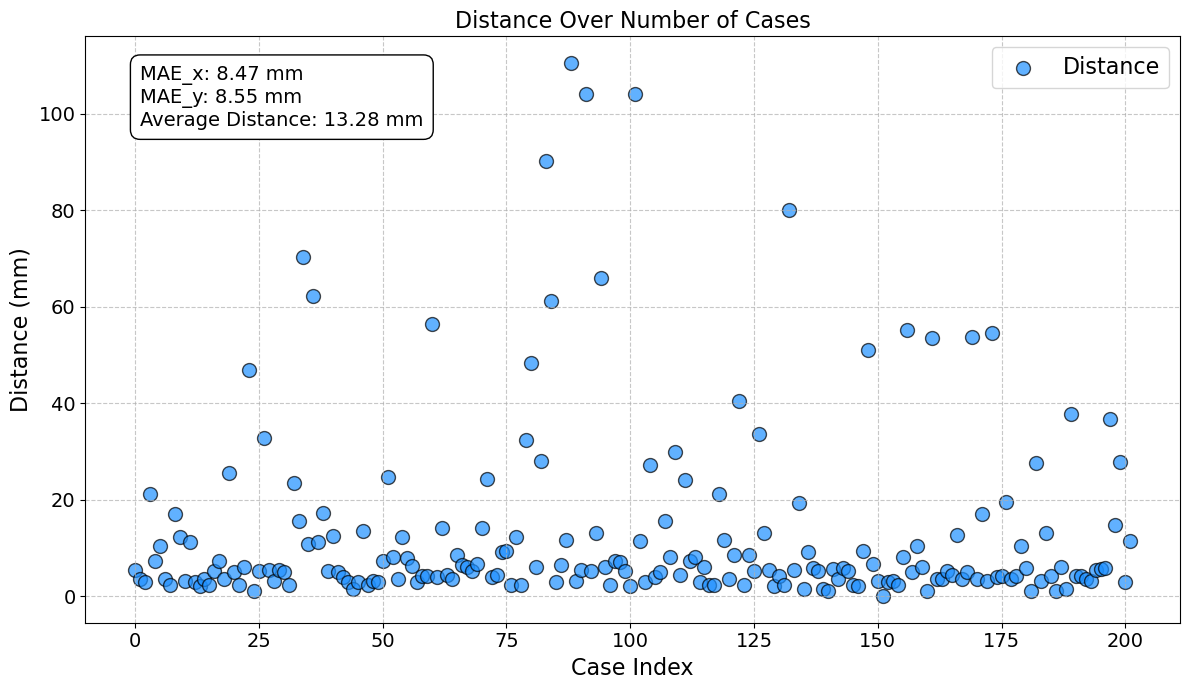

Mean Distance: 13.28


In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract test images, numerical data, and targets as lists
unbatched_data = list(test_dataset.unbatch().take(test_size).as_numpy_iterator())

test_images_tf = [item[0][0] for item in unbatched_data]  # Extract image part
test_numerical_tf = [item[0][1] for item in unbatched_data]  # Extract numerical part
test_targets_tf = [item[1] for item in unbatched_data]  # Extract target part

# Stack lists to TensorFlow tensors
test_images_tf = tf.stack(test_images_tf)
test_numerical_tf = tf.stack(test_numerical_tf)
test_targets_tf = tf.stack(test_targets_tf)

# Predict using the trained model
predictions = model.predict([test_images_tf, test_numerical_tf])

# Extract actual and predicted x, y values from targets and predictions
actual_x = test_targets_tf[:, 0]
actual_y = test_targets_tf[:, 1]
predicted_x = predictions[:, 0]
predicted_y = predictions[:, 1]

# Compute MAE and MSE for x and y
mae_x = mean_absolute_error(actual_x, predicted_x)
mse_x = mean_squared_error(actual_x, predicted_x)
mae_y = mean_absolute_error(actual_y, predicted_y)
mse_y = mean_squared_error(actual_y, predicted_y)

# Print MAE and MSE for x and y
print(f"MAE for x: {mae_x:.4f}")
print(f"MSE for x: {mse_x:.4f}")
print(f"MAE for y: {mae_y:.4f}")
print(f"MSE for y: {mse_y:.4f}")

# Calculate distances between actual and predicted coordinates
distance = np.sqrt((5 * actual_x - 5 * predicted_x)**2 + (5 * actual_y - 5 * predicted_y)**2)

# Calculate the mean distance
mean_distance = np.mean(distance)

# Generate an array of case indices (0, 1, 2, ..., n-1)
case_indices = np.arange(len(distance))

# Plotting distances as a scatter plot
plt.figure(figsize=(12, 7))
plt.scatter(case_indices, distance, color='dodgerblue', marker='o', edgecolor='black', s=100, alpha=0.7, label='Distance')
plt.xlabel('Case Index', fontsize=16)
plt.ylabel('Distance (mm)', fontsize=16)  # Ensure the unit is correct
plt.title('Distance Over Number of Cases', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Set custom ticks for x and y axes
plt.xticks(fontsize=14)  # Adjust x ticks font size
plt.yticks(fontsize=14)  # Adjust y ticks font size

# Prepare text box with metrics
textstr = (
    f'MAE_x: {5 * mae_x:.2f} mm\n'
    f'MAE_y: {5 * mae_y:.2f} mm\n'
    f'Average Distance: {mean_distance:.2f} mm'
)

# Place a text box in the upper left in axes coordinates
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

# Show plot
plt.tight_layout()
plt.show()

# Print the result
print(f"Mean Distance: {mean_distance:.2f}")
